In [1]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion 
from scipy.ndimage.morphology import iterate_structure

# Finding Local Peaks in a 2D Array

## Toy Problem

We want to find the primary points of contact made by puppy-paws on a pressure-sensor. There are 4 images that are 11x14 pixels. 

The pressure-heatmap data is given below:

In [2]:
paws = np.loadtxt('paws.txt').reshape(4, 11, 14)
print(paws.shape)

(4, 11, 14)


<IPython.core.display.Javascript object>


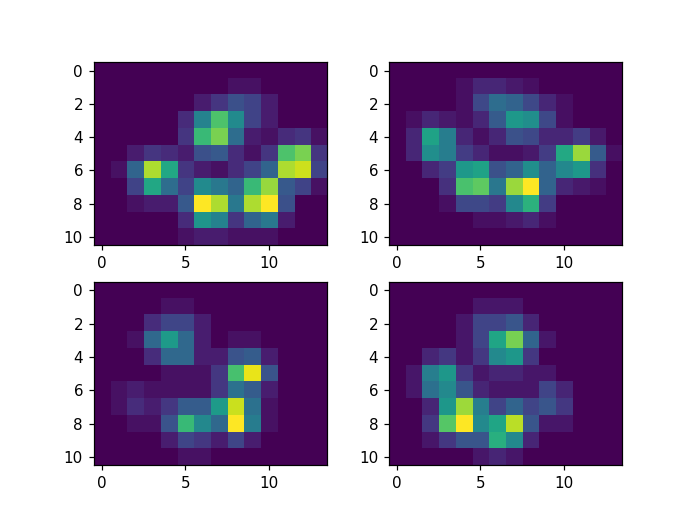

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=2)
for n, (i,j) in enumerate([(0,0), (0,1), (1,0), (1,1)]):
    ax[i, j].imshow(paws[n]);

For each "toe", we want to find the pixel with the maximum pressure. This corresponds to a finding the local peaks in a 2D image. This is much more nuanced than finding the global maximum. It is also not completely well defined - we need to specify what we mean by local.

### generate_binary_structure

We will use `scipy.ndimage.morphology.generate_binary_structure` to help us define the local neighborhood that we will consider, when looking for 2D peaks.

`generate_binary_structure` produces the "footprint" in which we look for neighbors. This is simply a 2D array of boolean values that indicate where, within the footprint, we want to look (i.e. `False` means ignore). Using `generate_binary_structure(rank=2,connectivity=1)` means that, for a given pixel, we will check its two vertical and two horizontal neighbors when checking for the local maximum.

Let's generate and visualize this specific footprint

In [4]:
generate_binary_structure(rank=2,connectivity=1)

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False]])

<IPython.core.display.Javascript object>


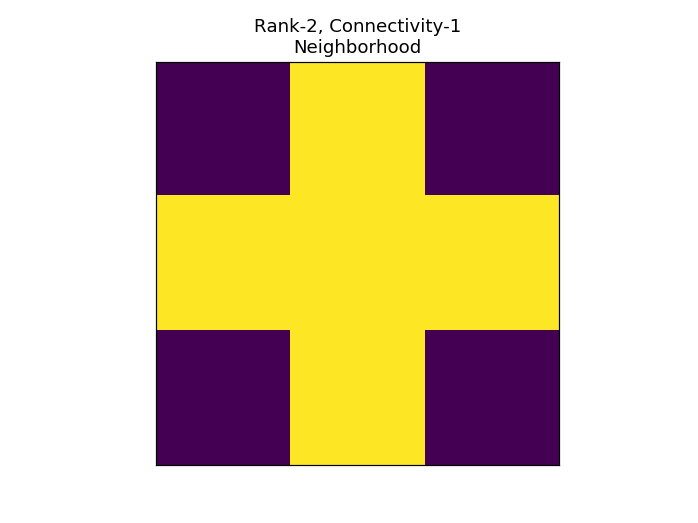

In [5]:
fig, ax = plt.subplots()
ax.imshow(generate_binary_structure(rank=2,connectivity=1))
ax.set_title("Rank-2, Connectivity-1\nNeighborhood")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([]);

What is the "footprint" produced by `generate_binary_structure(rank=2,connectivity=2)`? (The plot may be misleading, try printing out the array)

Boolean arrays behave like a binary mask when multiplied with a numerical array. Try multiplying the connectivity-1, rank-2 binary structure (which is a 2D array of booleans) by 2. Try to predict what the result will be before running your code.

In [6]:
generate_binary_structure(rank=2,connectivity=2) * 2

array([[2, 2, 2],
       [2, 2, 2],
       [2, 2, 2]])

### maximum_filter
`scipy.ndimage.filters.maximum_filter` is able to take a binary structure and use it to define a local "neighborhood", or "footprint" (wherever the footprint is `True`), within which it identifies the local maxima in an array. It rasters this footprint over our 2D array **with the footprint centered at each element**, and produces a 2D array of the same shape, but whose elements contain the local max values.

For example, consider the array of data:
```python
data = np.array([[ 4,  0,  5],
                 [ 2,  9,  1],
                 [10, -2,  1]])
```

Given the binary foot print:
```python
fp = np.array([[False,  True, False],
               [ True,  True,  True],
               [False,  True, False]], dtype=bool)
```

Using this footprint, `maximum_filter` will look at the entry-(0, 0) (which contains the number 4), above it, below it, to the left, and to the right, and will populate that position of the shape-(3, 3) output array with the maximum in that footprint. Because there is no entry above 4, or to the left, `maximum_filter` will "mirror" the data across the boundary. This 'mode' of dealing with the boundary can be changed (see the docstring). The maximum value here is 4.

`maximum_filter` places the footprint centered at each element of the data array and populates the corresponding element of the output with the maximum value from the footprint. What will be the output of  `maximum_filter(data, footprint=fp)` be? Determine this by hand before running the code.

Exercise: 

Given the data array
```python
data = np.array([[ 2,   14,  10,  5],
                 [ -1,  19,   1,  4],
                 [ 10,  -2,   7,  2],
                 [  9,   8,   4,  6]])
```

Find `fp` such that

```python
>>> maximum_filter(data, footprint=fp)
array([[19, 10, 19, 10],
       [14, 10, 14, 10],
       [19,  9, 19,  6],
       [10, 10,  8,  7]])
```

Hint: Start with the four elements in the middle of the output so that you don't need to worry about boundary effects at first. Keep in mind how border cases are handled by default


In [7]:
data = np.array([[ 2,   14,  10,  5],
                 [ -1,  19,   1,  4],
                 [ 10,  -2,   7,  2],
                 [  9,   8,   4,  6]])
fp = ([[True,False,True],
       [False,False,False],
       [True,False,True]])
maximum_filter(data, footprint=fp)

array([[19, 10, 19, 10],
       [14, 10, 14, 10],
       [19,  9, 19,  6],
       [10, 10,  8,  7]])

What if we want to use a larger footprint? We can make use of `scipy.ndimage.morphology.iterate_structure`. This allows us to set roughly the number of nearest neighbors (along a given direction) that that we want to included in the footprint.

For instance:
```python
>>> fp = generate_binary_structure(2,1)
>>> iterate_structure(fp, 2)
array([[False, False,  True, False, False],
       [False,  True,  True,  True, False],
       [ True,  True,  True,  True,  True],
       [False,  True,  True,  True, False],
       [False, False,  True, False, False]], dtype=bool)
```

<IPython.core.display.Javascript object>


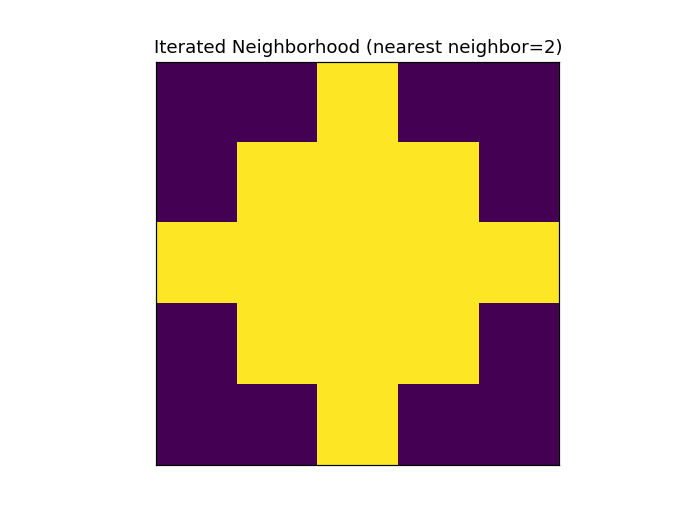

In [8]:
fig, ax = plt.subplots()
fp = generate_binary_structure(2,1)
ax.imshow(iterate_structure(fp, 2))
ax.set_title("Iterated Neighborhood (nearest neighbor=2)")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([]);

### Finding the Actual Peaks
What we are after are the local peaks in our data. `maximum_filter` essentially smears the local maxima over our data. We can simply see where our data matches with the max-filtered data - these points of agreement should be our local peaks!

That is
```python
peaks = (data == maximum_filter(data, footprint=fp))
```

`peaks` is thus an array of 1s wherever there is a local peak, and 0s elsewhere. Let's write a function that takes in a 2D array of data, and returns this binary indicator of the local peaks in the data. Let's use the rank-2, connectivity-2 footprint. Call the function `local_peaks_v1`. Thus "local" here means a 3x3 neighborhood.

In [9]:
def local_peaks_v1(data):
    fp = generate_binary_structure(rank=2,connectivity=2)
    peaks = (data == maximum_filter(data, footprint=fp))
    return peaks

from numba import njit

@njit()
def _peaks(spec, rows, cols, amp_min):
    peaks = []
    # We want to iterate over the array in column-major
    # order so that we order the peaks by time. That is,
    # we look for nearest neighbors of increasing frequencies
    # at the same times, and then move to the next time bin.
    # This is why we use the reversed-shape
    for c, r in np.ndindex(*spec.shape[::-1]):
        if spec[r, c] < amp_min:
            continue

        for dr, dc in zip(rows, cols):
            # don't compare element (r, c) with itself
            if dr == 0 and dc == 0:
                continue

            # mirror over array boundary
            if not (0 <= r + dr < spec.shape[0]):
                dr *= -1

            # mirror over array boundary
            if not (0 <= c + dc < spec.shape[1]):
                dc *= -1

            if spec[r, c] < spec[r + dr, c + dc]:
                break
        else:
            peaks.append((c, r))
    return peaks


def local_peaks(log_spectrogram, amp_min, p_nn):
    """
    Defines a local neighborhood and finds the local peaks
    in the spectrogram, which must be larger than the
    specified `amp_min`.

    Parameters
    ----------
    log_spectrogram : numpy.ndarray, shape=(n_freq, n_time)
        Log-scaled spectrogram. Columns are the periodograms of
        successive segments of a frequency-time spectrum.

    amp_min : float
        Amplitude threshold applied to local maxima

    p_nn : int
        Number of cells around an amplitude peak in the spectrogram in order

    Returns
    -------
    List[Tuple[int, int]]
        Time and frequency index-values of the local peaks in spectrogram.
        Sorted by ascending frequency and then time.

    Notes
    -----
    The local peaks are returned in column-major order for the spectrogram.
    That is, the peaks are ordered by time. That is, we look for nearest
    neighbors of increasing frequencies at the same times, and then move to
    the next time bin.
    """
    struct = generate_binary_structure(2, 1)
    neighborhood = iterate_structure(struct, p_nn)
    rows, cols = np.where(neighborhood)
    assert neighborhood.shape[0] % 2 == 1
    assert neighborhood.shape[1] % 2 == 1

    # center neighborhood indices around center of neighborhood
    rows -= neighborhood.shape[0] // 2
    cols -= neighborhood.shape[1] // 2

    detected_peaks = _peaks(log_spectrogram, rows, cols, amp_min=amp_min)

    # Extract peaks; encoded in terms of time and freq bin indices.
    # dt and df are always the same size for the spectrogram that is produced,
    # so the bin indices consistently map to the same physical units:
    # t_n = n*dt, f_m = m*df (m and n are integer indices)
    # Thus we can codify our peaks with integer bin indices instead of their
    # physical (t, f) coordinates. This makes storage and compression of peak
    # locations much simpler.

    return detected_peaks

Here is a function that will plot the paw prints next to the binary indicator of the local peaks.

In [10]:
def plot_compare(data, peak_finding_function):
    """ Plot the original data side-by-side with the binary indicator
        for the local peaks.
        
        Parameters
        ----------
        data : numpy.ndarray, shape=(N, H, W)
            N 2D arrays of shape (H, W)
            
        peak_finding_function : Callable[ndarray, ndarray]
            Returns local peak indicator for 2D array"""
    fig, ax = plt.subplots(nrows=len(data), ncols=2)
    for i, dat in enumerate(data):
        ax[i, 0].imshow(dat)
        ax[i, 1].imshow(peak_finding_function(dat))
    return fig, ax

Now plot a comparison to assess how well our peak-finding function works.

<IPython.core.display.Javascript object>


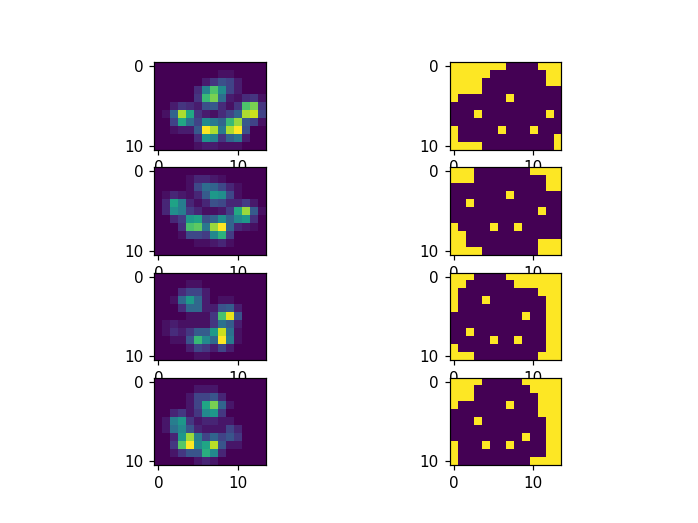

(<Figure size 640x480 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6a3025320>,
       dtype=object))

In [11]:
plot_compare(paws, local_peaks_v1)

What do you see in these right-column images? Are these precisely the results we are looking for? What do we need to add to our algorithm, if anything?
> SOLUTION: *SOLUTION HERE*

In [12]:
pass

Success! We are now finding local peaks in 2D data!

To summarize this process, we:
 - Determined a neighborhood that was appropriate for measuring local peaks.
 - Created a max-filtered version of our data.
 - Found the local peaks by finding where the data and the max-filtered data agree.
 - Demanded that our local peaks be in the "foreground" of our data.
 
This will be very useful to help us find the "fingerprint features" of a song, given its spectrogram (frequency vs time) data.

## Identifying "Foreground" vs "Background" in Real Data

Although this puppy paw print data set is pretty adorable, the fact that the paw print features are neatly embedded in a background of 0s is too convenient. In reality, you will likely face data where distinguishing background from a salient foreground is subtle (or perhaps entirely ill-posed).

Let's consider, for instance,  the spectrogram data for the trumpet waveform.

In [13]:
# running this cell loads the PCM-encoded data for the trumpet clip
with open("../fourier_materials/data/trumpet.txt", 'r') as R:
    trumpet_audio = np.asarray([int(i) for i in R])
    
sampling_rate = 44100 # sampling rate in Hz

<IPython.core.display.Javascript object>


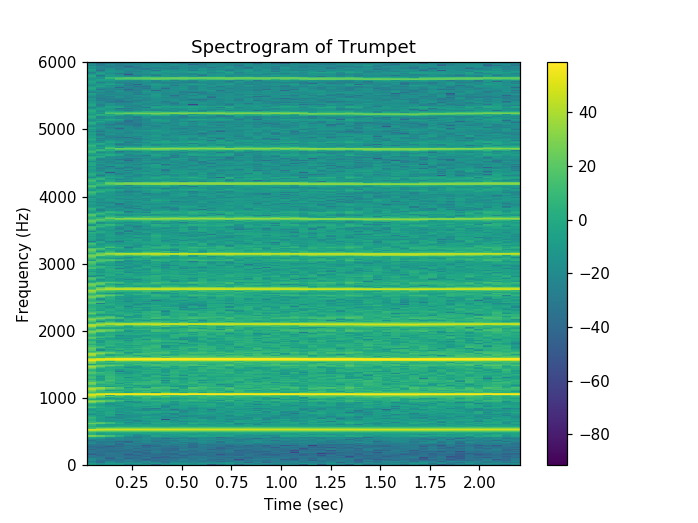

In [14]:
# using matplotlib's built-in spectrogram function
fig, ax = plt.subplots()

S, freqs, times, im = ax.specgram(trumpet_audio, NFFT=4096, Fs=sampling_rate,
                                  window=mlab.window_hanning,
                                  noverlap=4096 // 2)
fig.colorbar(im)

ax.set_xlabel("Time (sec)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Spectrogram of Trumpet")
ax.set_ylim(0, 6000);

To help us identify a "foreground" in the log-amplitudes of the spectrogram, we will plot the *cumulative distribution* of the log-amplitudes. This will allow us the threshold that delimits a given percentile of the amplitudes.

We will form a histogram of our Fourier coefficient log-amplitudes, $\log(|c_{k}|)$, using some bin size $\Delta c$ to bin those log-amplitudes. We will normalize the bin counts such that:

\begin{equation}
\sum_{i=0}^{N_{bin}}cnt_{i} \Delta c = 1
\end{equation}

That is, if you multiply the normalized histogram bin-count with the bin size and sum all of these terms, you get 1. This means that bin counts have been normalized such that the "area" of our histogram is 1.

Flatten your spectrogram data and pass it to the function `numpy.histogram`. If $N$ is the number of Fourier log-amplitudes, $\log(|c_{k}|)$, in your flattened spectrogram, then instruct the histogram to use $N/2$ bins. Also, be sure to specify `density=True` so that the bin counts are normalized to satisfy the above relationship. Be sure to read the "Returns" section of the doc-string for `numpy.histogram` to understand what the function returns. 

<IPython.core.display.Javascript object>


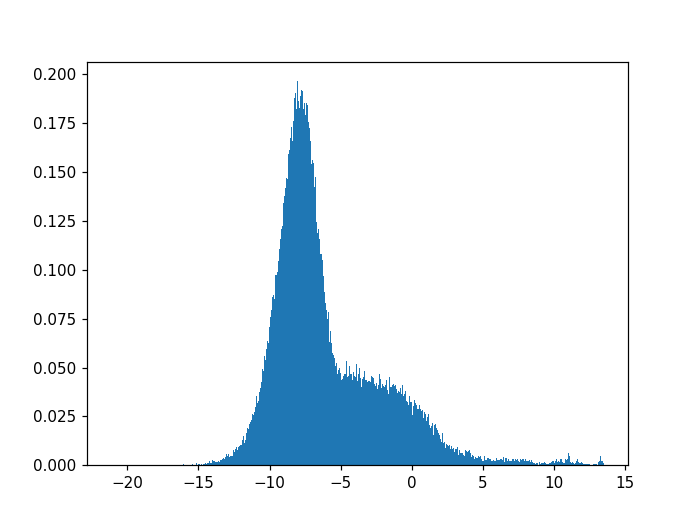

In [16]:
spec = (S.flatten())
histogram, edges = np.histogram(np.log(spec), bins = spec.size//2, density=True)

fig, ax = plt.subplots()

h=ax.hist(np.log(spec),bins=spec.size//200,density=True)

If you create a matplotlib figure via 

```python
fig, ax = plt.subplots()
``` 

You can use `ax.hist` in the exact same way as `numpy.histogram` but to plot this normalized histogram. Pass `ax.hist` the same arguments as `numpy.histogram` with one exception: **instruct the histogram to use $N/200$ bins instead of $N/2$**. Be  sure to label your axes.

In [17]:
#fig, ax = plt.subplots()
#plot = ax.hist(spec, bins=spec.size//2, density=True)

Using the output of `numpy.histogram`, check that the summation relation holds true; i.e. that the area of this histogram is 1.

In [18]:
dc = edges[1] - edges[0]
print(np.sum(histogram) * dc )

0.9999999999984313


Now that we have our normalized binned-counts of our amplitudes, we can form our cumulative distribution as follows:

\begin{equation}
F_{j} = \sum_{i=0}^{j}cnt_{i} \Delta c
\end{equation}

Where $F_{j}$ is the $j$th element in our cumulative distribution, for $j=0, 1, \cdots, (N_{bin}-1)$. Thus $F_{j}$ represents the total area of the histogram up to bin-$j$.

Compute the cumulative distribution $F$. Assign the variable `cumulative_distr` to the resulting array.

In [19]:
cumulative_distr = np.ndarray(histogram.size)
for i in range(histogram.size):
    cumulative_distr[i] = (np.sum(histogram[0:i]) * dc)
#print(np.sum(histogram) * dc)

Now plot $F_{j}$ vs $c_{j}$ where $c_{j} = \sum_{i=0}^{j}\Delta c$. Thus $c_{j}$ is the log-amplitude value associated with bin-$j$.

<IPython.core.display.Javascript object>


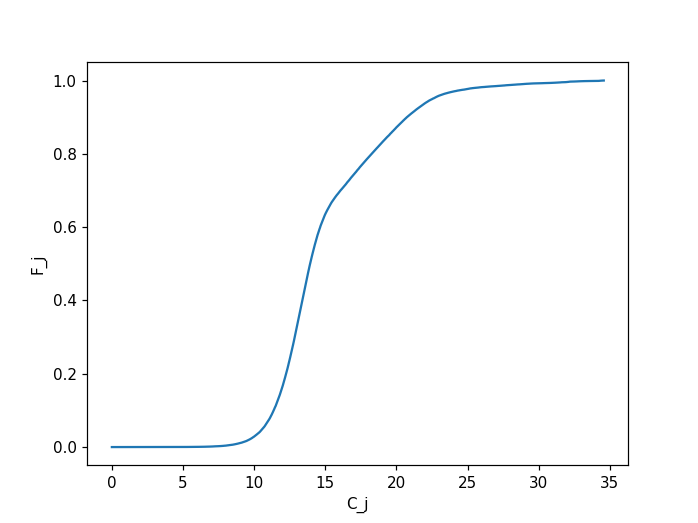

Text(0, 0.5, 'F_j')

In [57]:
fig, ax = plt.subplots()

c = np.arange(histogram.size) * dc

plot = ax.plot(c, cumulative_distr)

ax.set_xlabel("C_j")
ax.set_ylabel("F_j")

This distribution permits us to look up the percentiles of the log-amplitudes. For example, we can find the log-amplitude below which 80% of all the other present log-amplitudes fall. According to the plot above, we see that roughly 90% of all the log-amplitudes in our spectrogram fall beneath the value 0.

We can now consult this distribution when deciding how to distinguish between background and foregrounds. Suppose that we only want to detect peaks among the highest 10% of amplitudes present in the spectrogram. We want to lookup the log-amplitude in our cumulative distribution that maps to 0.9. 

`numpy.searchsorted` can be used to retrieve the index of `cumulative_distr` that is closest to 0.9, we can then use this index to determine which amplitude bin this corresponds to.

In [58]:
histogram[np.searchsorted(cumulative_distr, (0.9))]

0.043377719812240825

Thus 90% of all the log-amplitudes in the spectrogram fall below $-0.346$. Thus 90% of all of the Fourier coefficient amplitudes in this audio clip, $|c_{k}|$, fall beneath $e^{-0.346} \approx 0.71$. 

We could use this as a cutoff value of $-0.346$ for distinguishing foreground from background when finding peaks in the spectrogram for our trumpet audio clip!

Rewrite your local peaks function so that you can pass a cutoff value, where elements in your data that are less than or equal to that cutoff are considered "background".

In [19]:
pass